In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from metal.contrib.slicing.synthetics.geometric_synthetics import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


DATA_SEED = 2


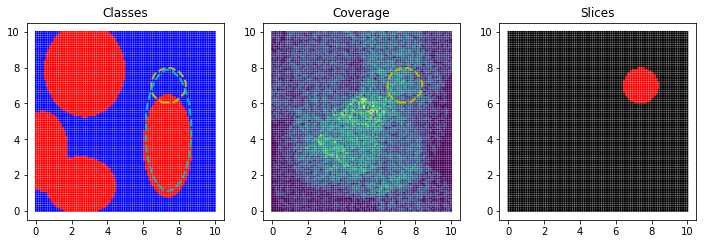

In [36]:
from scipy.sparse import csr_matrix

K = 2
M = 10
N = 10000
BATCHSIZE = 32
DATA_SEED = 2
print(f"DATA_SEED = {DATA_SEED}")

if DATA_SEED:
    random.seed(DATA_SEED)
    np.random.seed(DATA_SEED)
    _ = torch.manual_seed(DATA_SEED)
    
L_kwargs={
    "min_r": 1,
    "max_r": 5,
    "min_acc": 0.6,
    "max_acc": 0.9,
    "min_prop": 0.6,
    "max_prop": 0.9,
    "unipolar": False,
}
X_kwargs={"random": False}
Y_kwargs={"num_clusters": 4, "min_a": 1, "max_a": 3}
Z_kwargs={"num_slices": 4, "min_a": 1, "max_a": 2}
    
# Create background
canvas = Rectangle(0, 10, 0, 10)
X = create_points(canvas, N, **X_kwargs)
Y, label_regions = create_labels(X, K, **Y_kwargs)
L, lf_regions = create_lfs(X, Y, M, **L_kwargs)

# Create slice
Z = np.zeros(N)
slice_region = Circle(7.4,7,1)
Z = assign_y(X, Z, slice_region, 1)

# Create lf
lf_region = Ellipse(7.4, 4.5, 1.3, 3.4)
props = (0.9, 0.9)
accs = (0.95, 0.2)
l = assign_l(X, Y, lf_region, props, accs)
L = np.hstack((L, l.reshape(-1,1)))

# Plot
fig_size = 12
fig, axs = plt.subplots(1, 3, figsize=(fig_size, fig_size))
plt.sca(axs[0])
plot_labels(X, Y)
plot_region(X, slice_region, color='y')
plot_region(X, lf_region, color='c')
plt.sca(axs[1])
plot_coverage(X, L)
plot_region(X, slice_region, color='y')
plt.sca(axs[2])
plot_slices(X, Z)

# Standardize formats
L = csr_matrix(L)
X = torch.Tensor(X)

In [37]:
from metal.utils import split_data

Ls, Xs, Ys, Zs = split_data(L, X, Y, Z, splits=[0.5, 0.25, 0.25], shuffle=True)

In [38]:
from metal.analysis import lf_summary
lf_summary(L, Y)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1, 2]",0.0520,0.0502,0.0282,439,81,0.844231
1,"[1, 2]",0.1744,0.1694,0.1036,1166,578,0.668578
2,"[1, 2]",0.0443,0.0432,0.0292,277,166,0.625282
3,"[1, 2]",0.0567,0.0522,0.0253,412,155,0.726631
4,"[1, 2]",0.4723,0.4137,0.2112,3830,893,0.810925
5,"[1, 2]",0.1252,0.0928,0.0379,911,341,0.727636
6,"[1, 2]",0.1966,0.1911,0.1117,1706,260,0.867752
7,"[1, 2]",0.3138,0.2405,0.1361,2086,1052,0.664755
8,"[1, 2]",0.3132,0.2524,0.1249,2427,705,0.774904
9,"[1, 2]",0.0653,0.0364,0.0187,523,130,0.800919


In [39]:
from metal.contrib.backends.snorkel_gm_wrapper import SnorkelLabelModel

label_model = SnorkelLabelModel()
label_model.train_model(Ls[0])

from metal.metrics import accuracy_score

Y_train_ps = label_model.predict_proba(Ls[0])
Ys[0] = Y_train_ps

Y_dev_ps = label_model.predict_proba(Ls[0])
Y_dev_p = label_model.predict(Ls[1])
accuracy_score(Ys[1], Y_dev_p)

0.7644

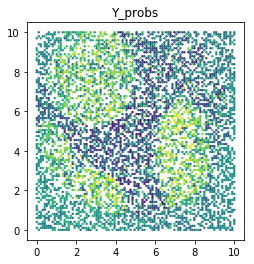

In [40]:
plot_probs(Xs[0], Y_train_ps[:,0], point_size=2)

In [41]:
import torch
from torch.utils.data import DataLoader
from metal.utils import SlicingDataset

Ls_tensors = [torch.Tensor(np.asarray(L.todense())) for L in Ls]

train_loader = DataLoader(
    SlicingDataset(Ls_tensors[0], Xs[0], Y_train_ps, Zs[0]),
    batch_size=BATCHSIZE,
    shuffle=True
)

dev_loader = DataLoader(SlicingDataset(Ls_tensors[1], Xs[1], Ys[1], Zs[1]))
test_loader = DataLoader(SlicingDataset(Ls_tensors[1], Xs[2], Ys[2], Zs[2]))

In [44]:
import os
from metal.contrib.slicing.metrics import calc_slice_acc, calc_heads_acc

# MODEL_SEED = np.random.randint(1e6)
MODEL_SEED = 123
print(f"model_seed: {MODEL_SEED}")

RUN_NAME = f"{DATA_SEED}_{MODEL_SEED}_SM"

em_config = {
    "layer_out_dims": [2, 5, 5, 2],
    "verbose": False,
    "seed": MODEL_SEED,
}

sm_config = {
    "L_weight": 0.2,
    "Y_off_weight": 0.1,
    "vanilla": False,
    "online_head": True,
    "indicator": False,
    "mask_abstains": True,
    "verbose": True,
}

train_kwargs = {
    "n_epochs": 20,
    "lr": 0.001,
    "l2": 0.0,
    "log_unit": "epochs",
#     "log_train_metrics_func": None,
#     "log_train_metrics": ["loss"],
    "log_train_every": 1,
    "log_valid_every": 1,
    "log_valid_metrics_func": [calc_slice_acc], # calc_heads_acc],
#     "log_valid_metrics": ["L_acc", "Y_off_acc", "Y_on_acc"],
    "checkpoint": True,
#     "checkpoint_metric": "Y_on_acc",
    "writer": "tensorboard",
    "log_dir": f"{os.environ['METALHOME']}/tensorboard/",
    "run_name": RUN_NAME,
}

model_seed: 123


In [45]:
from metal.end_model import EndModel
from metal.contrib.slicing.slice_model import SliceMaster
from metal.contrib.slicing.experiment_utils import eval_model

base_model = EndModel(**em_config)
model = SliceMaster(base_model, m=Ls[0].shape[1], **sm_config)
model.train_model(train_loader, valid_data=dev_loader, **train_kwargs)
# model.score(test_loader)
# calc_slice_accuracy(model, test_loader)
results = eval_model(model, test_loader, verbose=False)

Resetting base model parameters
SliceMaster(
  (body): Sequential(
    (0): IdentityModule()
    (1): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=5, out_features=5, bias=True)
      (1): ReLU()
    )
  )
  (L_head): Linear(in_features=5, out_features=11, bias=False)
  (L_criteria): BCEWithLogitsLoss()
  (Y_head_off): Linear(in_features=5, out_features=1, bias=True)
  (Y_criteria): BCEWithLogitsLoss()
  (Y_head_on): Linear(in_features=5, out_features=1, bias=True)
)

[1 epo]: TRAIN:[loss=0.582] VALID:[slice_1=0.778, accuracy=0.474]
Saving model at iteration 1 with best score 0.474
[2 epo]: TRAIN:[loss=0.579] VALID:[slice_1=0.778, accuracy=0.636]
Saving model at iteration 2 with best score 0.636
[3 epo]: TRAIN:[loss=0.578] VALID:[slice_1=0.778, accuracy=0.638]
Saving model at iteration 3 with best score 0.638
[4 epo]: TRAIN:[loss=0.577] VALID:[slice_1=0.778, accuracy=0.632]
[5 epo]: TRA